In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import time
# from scipy.stats import gaussian_kde
# import scipy.stats as stats

In [2]:
# To import dataset and time_series_models succesful,
# here need to set correct path
import sys
import os
current_dir = os.path.dirname(os.path.abspath(''))
parent_dir = os.path.dirname(current_dir)

# here add current path. Please check the value of current_dir and parent_dir
sys.path.append(current_dir)

In [3]:
from dataset import CO2_synthetic_dataset 
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset, Attention

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
import kgml_lib
Z_norm_reverse = kgml_lib.Z_norm_reverse
Z_norm_with_scaler = kgml_lib.Z_norm_with_scaler

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

input_data = 'recotest_data_scaled_v4_100sample.sav'
sample_index_file = "traindataset_split_year_v1.sav"

pretrained_model = "recotest_v11_exp4.sav_step1"
output_model = "recotest_v11_exp4_sample.sav_step2"
synthetic_data = "sys_data2.sav"

dataset = CO2_synthetic_dataset(data_path, input_data, output_path, sample_index_file)
dataset.load_step2_data()

dataset.prepare_step2_data()

torch.Size([6570, 100, 19]) torch.Size([6570, 100, 3]) torch.Size([18, 100, 1])
['RADN', 'TMAX_AIR', 'TDIF_AIR', 'HMAX_AIR', 'HDIF_AIR', 'WIND', 'PRECN', 'Crop_Type', 'GPP', 'Year', 'TBKDS', 'TSAND', 'TSILT', 'TFC', 'TWP', 'TKSat', 'TSOC', 'TPH', 'TCEC']


In [7]:
X = dataset.X  #[365*18, 100, 19]
X = torch.transpose(X,1, 0) #[100, 365*18, 19]

Y1 = dataset.Y1 #[365*18, 100, 3]
Y1 = torch.transpose(Y1,1, 0) #[100, 365*18, 3]

Y2 = dataset.Y2 #[18, 100, 1]
Y2 = torch.transpose(Y2,1, 0)

y_scaler = dataset.Y1_scaler

In [8]:
X.shape, Y1.shape

(torch.Size([100, 6570, 19]), torch.Size([100, 6570, 3]))

In [9]:
num_input_features = 19
num_output_features = 3

input_dim = num_input_features
hidden_dim = 128
num_layers = 3
output_dim = num_output_features
dropout=0.2

In [10]:
# from customize_module import FlexibleModelCompiler
from customize_module import FlexibleModelCompiler

In [11]:
config = {
    'class_name': 'my_KGML',
    'base_class': 'TimeSeriesModel',
    'init_params': {
        'input_dim': 19,
        'hidden_dim': 128,
        'num_layers': 2,
        'output_dim': 3,
        'dropout': 0.2
    },
    'layers': {
            'gru_basic': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'),
            'gru_ra':    ('gru', 'input_dim + 2*hidden_dim', 'hidden_dim', 'num_layers', 'dropout'), # Note, 2* hidden_dim
            'gru_rh':    ('gru', 'input_dim + 2*hidden_dim', 'hidden_dim', '1', '0'),
            'gru_nee':   ('gru', 'input_dim+2', 'hidden_dim', '1', '0'), # num_layers is 1, dropout is 0
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
            'attn':      ('Attention', 'hidden_dim', 'hidden_dim*2'), # output will be 2* hidden_dim
    },
    'forward': {
        'out_basic, hidden': 'gru_basic(x)',
        'dropped':   'dropout(out_basic)',
        'attend':    'attn(dropped)', # output size is 2* hidden_dim
        'ra_in':     'attend & x',    # & means concencate two matrix
        'ra_out, hidden':    'gru_ra(ra_in)',
        'ra_pred':   'fc(dropout(ra_out))',
        'rh_in':     'attend & x',
        'rh_out, hidden':    'gru_rh(rh_in)',
        'rh_pred':   'fc(dropout(rh_out))',
        'nee_in':    'ra_pred & rh_pred & x',
        'nee_out, hidden':   'gru_nee(nee_in)',
        'nee_pred':  'fc(dropout(nee_out))',
        'output':    'ra_pred & rh_pred & nee_pred'
    }
}

In [13]:
compiler = FlexibleModelCompiler(config)
compiler.check_configuration()
myKGML = compiler.generate_model()
print("\n Generated class code:")
print(compiler.class_code)


 Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.gru_basic = nn.GRU(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_ra = nn.GRU(input_dim + 2*hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_rh = nn.GRU(input_dim + 2*hidden_dim, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.gru_nee = nn.GRU(input_dim+2, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.attn = Attention(hidden_dim)

    def forwar

In [14]:
model = myKGML(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [15]:
total_years = 18
# days_per_year = 365
# total_days = total_years * days_per_year
# num_sites = X.shape[0] #100

batch_size=64

model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

In [19]:
learning_rate = 0.001
step_size = 40
max_epoch = 200
gamma = 0.8
loss_function = nn.L1Loss() # nn.MSELoss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/200 | LR: 0.001000, Train Loss: 0.5863, Test Loss: 0.4579
Epoch 2/200 | LR: 0.001000, Train Loss: 0.4187, Test Loss: 0.3334
Epoch 3/200 | LR: 0.001000, Train Loss: 0.3247, Test Loss: 0.2775
Epoch 4/200 | LR: 0.001000, Train Loss: 0.2691, Test Loss: 0.2526
Epoch 5/200 | LR: 0.001000, Train Loss: 0.2392, Test Loss: 0.2251
Epoch 6/200 | LR: 0.001000, Train Loss: 0.2226, Test Loss: 0.2126
Epoch 7/200 | LR: 0.001000, Train Loss: 0.2089, Test Loss: 0.2034
Epoch 8/200 | LR: 0.001000, Train Loss: 0.1980, Test Loss: 0.1954
Epoch 9/200 | LR: 0.001000, Train Loss: 0.1888, Test Loss: 0.1909
Epoch 10/200 | LR: 0.001000, Train Loss: 0.1808, Test Loss: 0.1883
Epoch 11/200 | LR: 0.001000, Train Loss: 0.1760, Test Loss: 0.1828
Epoch 12/200 | LR: 0.001000, Train Loss: 0.1720, Test Loss: 0.1796
Epoch 13/200 | LR: 0.001000, Train Loss: 0.1675, Test Loss: 0.1753
Epoch 14/200 | LR: 0.001000, Train Loss: 0.1619, Test Loss: 0.1759
Epoch 15/200 | LR: 0.001000, Train Loss: 0.1606, Test Loss: 0.1803
Epoc

In [20]:
model.test()

Test Loss: 0.1638


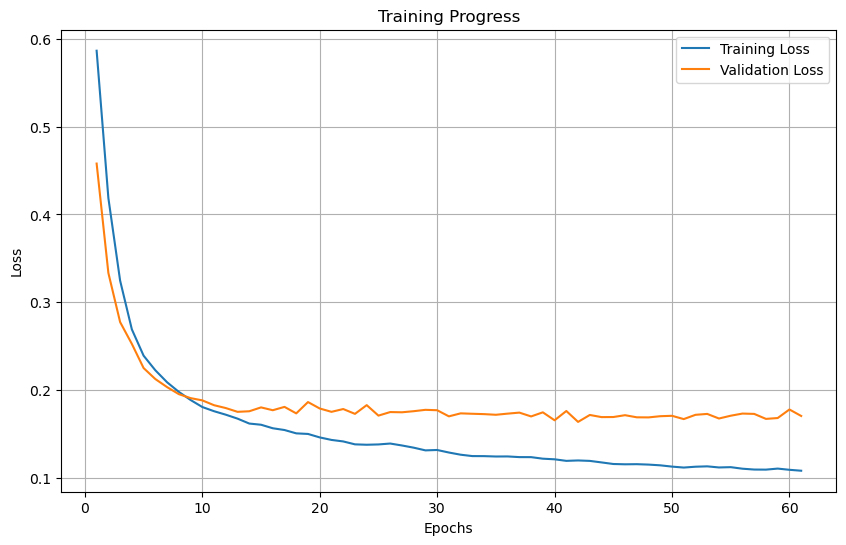

In [21]:
model.plot_training_curves()

In [23]:
output_feature_name = ['Ra','Rh','NEE']
model.get_R2_score(y_scaler, output_feature_name)

Feature Ra R2 Score is: 0.9622340603551618
Feature Rh R2 Score is: 0.8032043642197597
Feature NEE R2 Score is: 0.9377759616396769


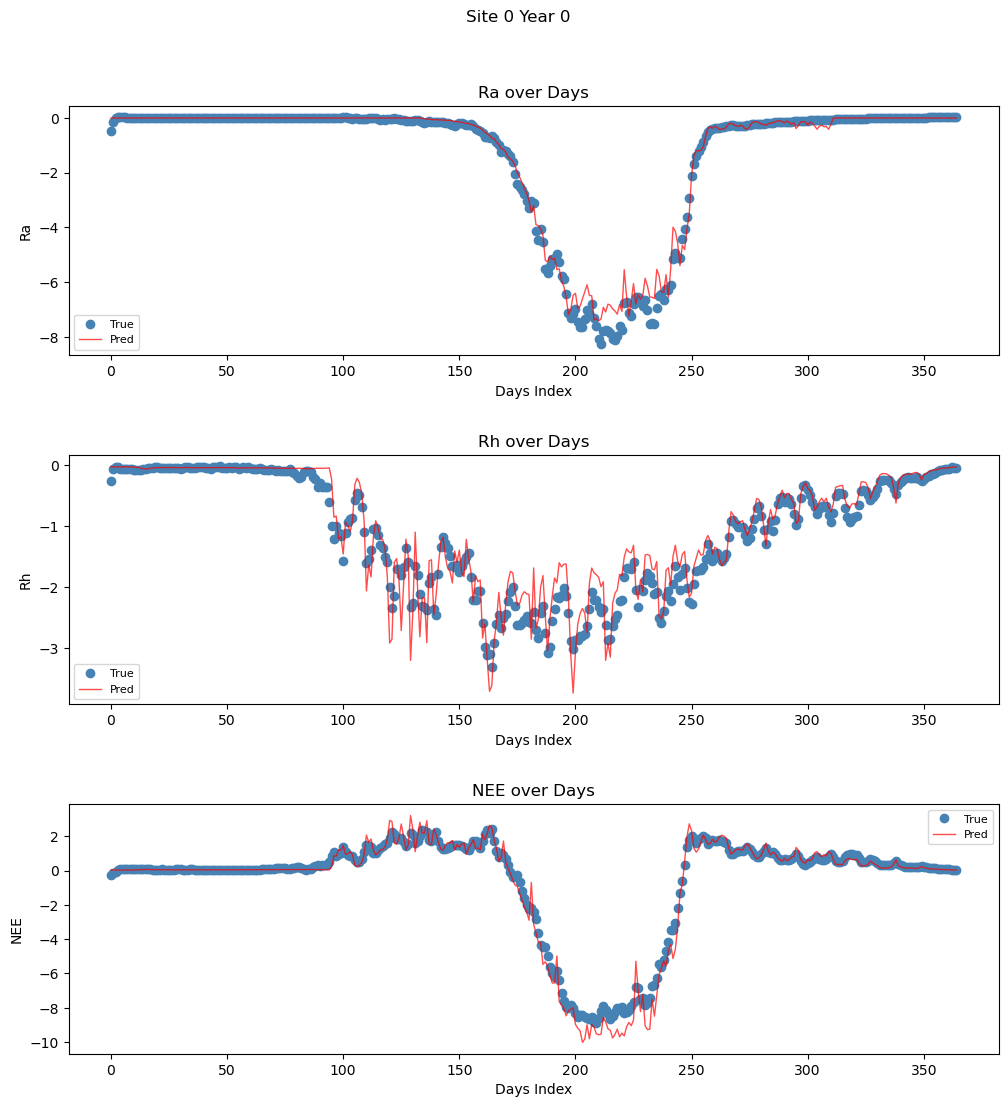

In [24]:
model.Vis_plot_prediction_result_time_series(y_scaler, output_feature_name, site=0, year=0)

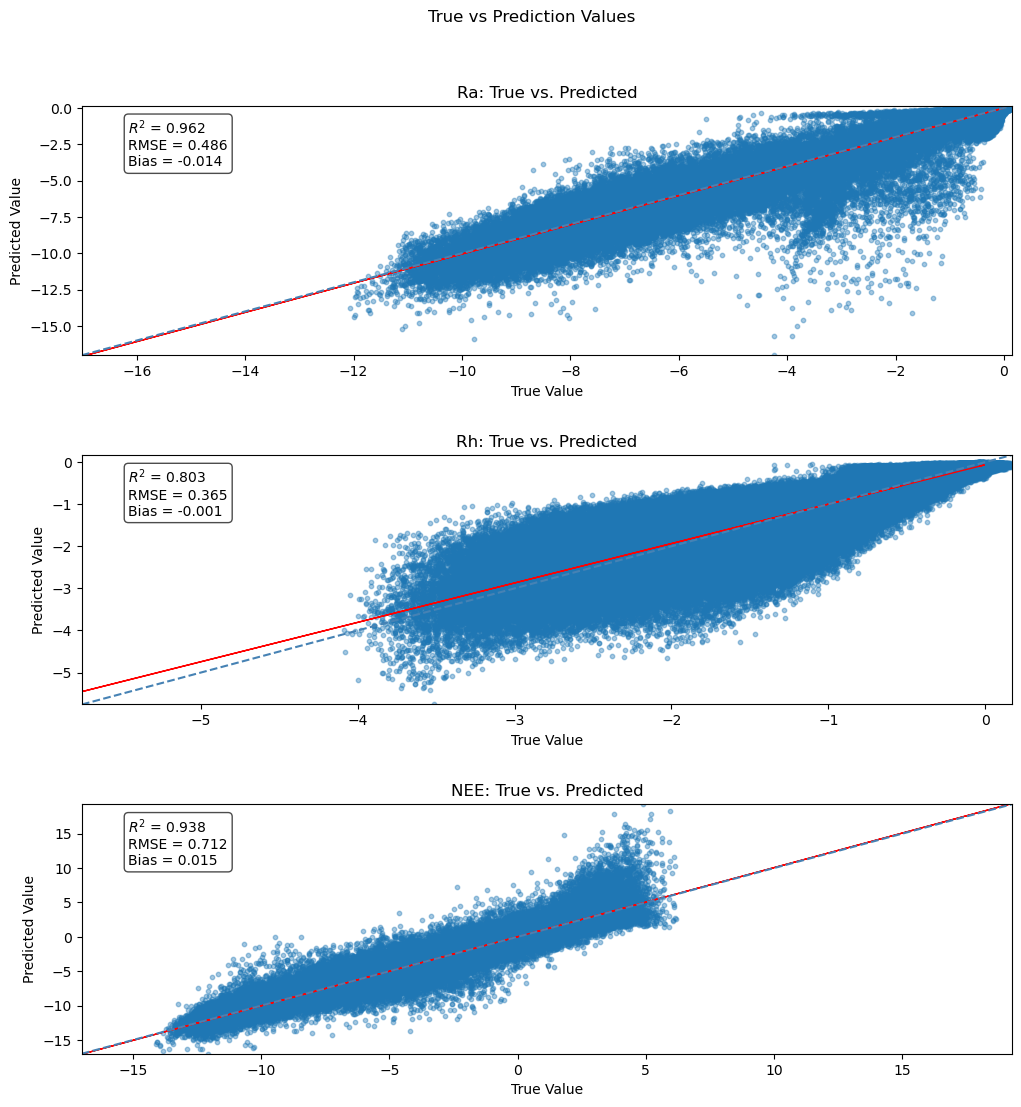

In [25]:
model.Vis_scatter_prediction_result(y_scaler, output_feature_name)

## Show some case of configuration

In [16]:
# Attention head 
config_attn = {
        'class_name': 'my_attention',
        'base_class': 'nn.Module',
        'init_params': {
            'hidden_dim': 128,
        },
        'layers': {
            'fc1':        ('linear', 'hidden_dim', '64'),
            'relu': ('relu',),
            'fc2': ('linear', '64', '64'),
            'fc3': ('linear', '64', '32'),
            'fc4': ('linear', '32', '1'),
            'tanh': ('tanh',)
        },
        'forward': {
            'x1': 'fc1(x)',
            'x2':   'relu(x1)',
            'x3':    'fc2(x2)',
            'x4':     'relu(x3)',
            'x5':    'fc3(x4)',
            'x6':   'relu(x5)',
            'x7':    'fc4(x6)',
            'x8':   'tanh(x7)',
            'output':    'x8'
        }
    }

In [18]:
Compiler_attn = FlexibleModelCompiler(config_attn)
Compiler_attn.check_configuration()
my_atten = Compiler_attn.generate_model()

print("\n Generated class code:")
print(Compiler_attn.class_code)


 Generated class code:
class my_attention(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.hidden_dim = hidden_dim

        self.fc1 = nn.Linear(hidden_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor):
        # Copy parameter to local
        hidden_dim = self.hidden_dim

        x1 = self.fc1(x)
        x2 = self.relu(x1)
        x3 = self.fc2(x2)
        x4 = self.relu(x3)
        x5 = self.fc3(x4)
        x6 = self.relu(x5)
        x7 = self.fc4(x6)
        x8 = self.tanh(x7)
        output = x8
        return output


In [17]:
# KGML module use different kind of Attention
config_kgml = {
        'class_name': 'my_KGML',
        'base_class': 'TimeSeriesModel',
        'init_params': {
            'input_dim': 19, # number of input features
            'hidden_dim': 128,
            'num_layers': 2,
            'output_dim': 3,
            'dropout': 0.2
        },
        'layers': {
            'gru_basic': ('gru', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'), # basic
            'gru_ra':    ('gru', 'input_dim + 2*hidden_dim', 'hidden_dim', 'num_layers', 'dropout'), # Ra prediction
            'gru_rh':    ('gru', 'input_dim + 2*hidden_dim', 'hidden_dim', '1', '0'),
            'gru_nee':   ('gru', 'input_dim+2', 'hidden_dim', '1', '0'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
            'attn1':      ('Attention', 'hidden_dim', '2*hidden_dim'), # Use predefined Attention class
            # Another attention module
            'attn2': ('Sequential', 'nn.Linear(hidden_dim, 64)', 'nn.ReLU()', 'nn.Linear(64, 64)', 'nn.ReLU()', 
                      'nn.Linear(64, 32)', 'nn.ReLU()', 'nn.Linear(32, 1)', 'nn.Tanh()'),
            'attn3': ('my_attention', 'hidden_dim', '1') # use attenstion which defined in previous block
        },
        'forward': {
            # gru layer return two parameters, ignore hidden
            'out_basic, hidden': 'gru_basic(x)',
            'dropped':   'dropout(out_basic)',
            'attend':    'attn3(dropped)',
            'ra_in':     'attend & x',
            'ra_out, hidden':    'gru_ra(ra_in)',  # Ignor hidden
            'ra_pred':   'fc(dropout(ra_out))',
            'rh_in':     'attend & x',
            'rh_out, hidden':    'gru_rh(rh_in)',
            'rh_pred':   'fc(dropout(rh_out))',
            'nee_in':    'ra_pred & rh_pred & x',
            'nee_out, hidden':   'gru_nee(nee_in)',
            'nee_pred':  'fc(dropout(nee_out))',
            'output':    'ra_pred & rh_pred & nee_pred'
        }
    }

In [19]:
Compiler_kgml = FlexibleModelCompiler(config_kgml)
Compiler_kgml.check_configuration()
myKGML = Compiler_kgml.generate_model()
print("\n Generated class code:")
print(Compiler_kgml.class_code)

Warning check ra_in in the gru_ra(ra_in)
Warning check rh_in in the gru_rh(rh_in)

 Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.gru_basic = nn.GRU(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_ra = nn.GRU(input_dim + 2*hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_rh = nn.GRU(input_dim + 2*hidden_dim, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.gru_nee = nn.GRU(input_dim+2, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc = 

In [20]:
# Multitple LSTM layers
config_kgml = {
        'class_name': 'my_KGML',
        'base_class': 'TimeSeriesModel',
        'init_params': {
            'input_dim': 19, # number of input features
            'hidden_dim': 128,
            'num_layers': 2,
            'output_dim': 3,
            'dropout': 0.2
        },
        'layers': {
            'lstm_basic': ('lstm', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'), # basic by using LSTM
            'lstm_ra':    ('lstm', 'input_dim + 2*hidden_dim', 'hidden_dim', 'num_layers', 'dropout'), # Ra prediction
            'lstm_rh':    ('lstm', 'input_dim + 2*hidden_dim', 'hidden_dim', '1', '0'),
            'lstm_nee':   ('lstm', 'input_dim+2', 'hidden_dim', '1', '0'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
            'attn1':      ('Attention', 'hidden_dim', 'hidden_dim*2'), # Use predefined Attention class
        },
        'forward': {
            # gru layer return two parameters, ignore hidden
            'out_basic, hidden': 'lstm_basic(x)',
            'dropped':   'dropout(out_basic)',
            'attend':    'attn1(dropped)',
            'ra_in':     'attend & x',
            'ra_out, hidden':    'lstm_ra(ra_in)',  # Ignor hidden
            'ra_pred':   'fc(dropout(ra_out))',
            'rh_in':     'attend & x',
            'rh_out, hidden':    'lstm_rh(rh_in)',
            'rh_pred':   'fc(dropout(rh_out))',
            'nee_in':    'ra_pred & rh_pred & x',
            'nee_out, hidden':   'lstm_nee(nee_in)',
            'nee_pred':  'fc(dropout(nee_out))',
            'output':    'ra_pred & rh_pred & nee_pred'
        }
    }

In [21]:
Compiler = FlexibleModelCompiler(config_kgml)
Compiler.check_configuration()
myKGML = Compiler.generate_model()
print("\n Generated class code:")
print(Compiler.class_code)


 Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.lstm_basic = nn.LSTM(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.lstm_ra = nn.LSTM(input_dim + 2*hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.lstm_rh = nn.LSTM(input_dim + 2*hidden_dim, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.lstm_nee = nn.LSTM(input_dim+2, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.attn1 = Attention(hidden_dim)

    d

In [22]:
# Mix LSTM and GRU layers
config_kgml = {
        'class_name': 'my_KGML',
        'base_class': 'TimeSeriesModel',
        'init_params': {
            'input_dim': 19, # number of input features
            'hidden_dim': 128,
            'num_layers': 2,
            'output_dim': 3,
            'dropout': 0.2
        },
        'layers': {
            'lstm_basic': ('lstm', 'input_dim', 'hidden_dim', 'num_layers', 'dropout'), # basic by using LSTM
            'gru_ra':    ('gru', 'input_dim + 2*hidden_dim', 'hidden_dim', 'num_layers', 'dropout'), # Ra prediction
            'gru_rh':    ('gru', 'input_dim + 2*hidden_dim', 'hidden_dim', '1', '0'),
            'lstm_nee':   ('lstm', 'input_dim+2', 'hidden_dim', '1', '0'),
            'dropout':   ('dropout', 'dropout'),
            'fc':        ('linear', 'hidden_dim', '1'),
            'attn1':      ('Attention', 'hidden_dim', 'hidden_dim*2'), # Use predefined Attention class
        },
        'forward': {
            # gru layer return two parameters, ignore hidden
            'out_basic, hidden': 'lstm_basic(x)',
            'dropped':   'dropout(out_basic)',
            'attend':    'attn1(dropped)',
            'ra_in':     'attend & x',
            'ra_out, hidden':    'gru_ra(ra_in)',  # Ignor hidden
            'ra_pred':   'fc(dropout(ra_out))',
            'rh_in':     'attend & x',
            'rh_out, hidden':    'gru_rh(rh_in)',
            'rh_pred':   'fc(dropout(rh_out))',
            'nee_in':    'ra_pred & rh_pred & x',
            'nee_out, hidden':   'lstm_nee(nee_in)',
            'nee_pred':  'fc(dropout(nee_out))',
            'output':    'ra_pred & rh_pred & nee_pred'
        }
    }

In [23]:
Compiler = FlexibleModelCompiler(config_kgml)
Compiler.check_configuration()
myKGML = Compiler.generate_model()
print("\n Generated class code:")
print(Compiler.class_code)


 Generated class code:
class my_KGML(TimeSeriesModel):
    def __init__(self, input_dim=19, hidden_dim=128, num_layers=2, output_dim=3, dropout=0.2):
        super().__init__(input_dim, hidden_dim, num_layers, output_dim, dropout)

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout

        self.lstm_basic = nn.LSTM(input_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_ra = nn.GRU(input_dim + 2*hidden_dim, hidden_dim, num_layers, bias=True, batch_first=True, dropout=dropout)
        self.gru_rh = nn.GRU(input_dim + 2*hidden_dim, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.lstm_nee = nn.LSTM(input_dim+2, hidden_dim, 1, bias=True, batch_first=True, dropout=0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.attn1 = Attention(hidden_dim)

    def f

In [24]:
# Attention module
dual_attn = {
        'class_name': 'dual_attention',
        'base_class': 'nn.Module',
        'init_params': {
            'hidden_dim': 128,
        },
        'layers':{
            'fc':        ('linear', 'hidden_dim', 'hidden_dim'),

        },
        'forward': {
            'Q': 'fc(x)',
            'K': 'fc(x)',
            'V': 'fc(x)',
            '_scores': 'Q @ K.transpose(1, 2)',  # @ means matrix multiple, torch.bmm(Q, K.transpose(1, 2)) / self.scale
            'scores': '_scores/ (hidden_dim**0.5)',
            'attention_weights': 'F.softmax(scores, dim=-1)',
            'context': 'attention_weights @ V', #torch.bmm(attention_weights, V)
            'output': 'x & context',
        }
    }

In [25]:
Compiler2 = FlexibleModelCompiler(dual_attn)
Compiler2.check_configuration()
Compiler2.generate_model()
print("\n Generated class code:")
print(Compiler2.class_code)


 Generated class code:
class dual_attention(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()

        self.hidden_dim = hidden_dim

        self.fc = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, x: torch.Tensor):
        # Copy parameter to local
        hidden_dim = self.hidden_dim

        Q = self.fc(x)
        K = self.fc(x)
        V = self.fc(x)
        _scores = torch.bmm(Q, K.transpose(1, 2))
        scores = _scores/ (hidden_dim**0.5)
        attention_weights = F.softmax(scores, dim=-1)
        context = torch.bmm(attention_weights, V)
        output = torch.cat([x, context], dim=-1)
        return output


In [50]:
model = myKGML(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [51]:
total_years = 18
batch_size=64
model.train_test_split(X, Y1, total_years, batch_size, split_method=1)

In [53]:
learning_rate = 0.001
step_size = 40
max_epoch = 20
gamma = 0.8
loss_function = nn.L1Loss() # nn.MSELoss()

# model.train_model(train_loader, test_loader, LR= learning_rate, step_size=20, gamma=0.8, maxepoch=60)
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch)

Epoch 1/20 | LR: 0.001000, Train Loss: 0.1885, Test Loss: 0.2112
Epoch 2/20 | LR: 0.001000, Train Loss: 0.1616, Test Loss: 0.1975
Epoch 3/20 | LR: 0.001000, Train Loss: 0.1514, Test Loss: 0.1884
Epoch 4/20 | LR: 0.001000, Train Loss: 0.1457, Test Loss: 0.1932
Epoch 5/20 | LR: 0.001000, Train Loss: 0.1421, Test Loss: 0.2023
Epoch 6/20 | LR: 0.001000, Train Loss: 0.1408, Test Loss: 0.1872
Epoch 7/20 | LR: 0.001000, Train Loss: 0.1379, Test Loss: 0.1876
Epoch 8/20 | LR: 0.001000, Train Loss: 0.1356, Test Loss: 0.1907
Epoch 9/20 | LR: 0.001000, Train Loss: 0.1333, Test Loss: 0.1932
Epoch 10/20 | LR: 0.001000, Train Loss: 0.1327, Test Loss: 0.1921
Epoch 11/20 | LR: 0.001000, Train Loss: 0.1306, Test Loss: 0.1911
Epoch 12/20 | LR: 0.001000, Train Loss: 0.1294, Test Loss: 0.1833
Epoch 13/20 | LR: 0.001000, Train Loss: 0.1270, Test Loss: 0.1867
Epoch 14/20 | LR: 0.001000, Train Loss: 0.1257, Test Loss: 0.1842
Epoch 15/20 | LR: 0.001000, Train Loss: 0.1249, Test Loss: 0.1913
Epoch 16/20 | LR: 0